In [1]:
# Imports
import pathlib
import csv
import os
import cv2

import random
import numpy as np
#from tqdm.auto import tqdm
from PIL import Image, ImageEnhance

#from IPython.display import display
import matplotlib.pyplot as plt

import torch
#import torch.nn as nn
#import torch.optim as optim

#from torchvision.utils import make_grid
import torchvision.transforms as transforms
#from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import Lambda

In [2]:
# @markdown `shuffle-spli and dataset constructor`
def shuffle_and_split_data(X, y, seed, split_percent=0.2):
  """
  Helper function to shuffle and split data, yoinked from W1D3 tutorial

  Args:
    X: torch.tensor
      Input data
    y: torch.tensor
      Corresponding target variables
    seed: int
      Set seed for reproducibility

  Returns:
    X_test: torch.tensor
      Test data [20% of X]
    y_test: torch.tensor
      Labels corresponding to above mentioned test data
    X_train: torch.tensor
      Train data [80% of X]
    y_train: torch.tensor
      Labels corresponding to above mentioned train data
  """
  # Set seed for reproducibility
  torch.manual_seed(seed)
  # Number of samples
  N = X.shape[0]
  # Shuffle data
  shuffled_indices = torch.randperm(N)   # Get indices to shuffle data, could use torch.randperm
  X = X[shuffled_indices]
  y = y[shuffled_indices]

  # Split data into train/test
  test_size = int(split_percent * N)    # Assign test datset size using 20% of samples
  X_test = X[:test_size]
  y_test = y[:test_size]
  X_train = X[test_size:]
  y_train = y[test_size:]

  return X_test, y_test, X_train, y_train

In [3]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [4]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.
# NOTE: This is mostly a GPU free tutorial.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook.")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [5]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook.


In [6]:
# Corruption functions
def add_salt_and_pepper_noise(image):
    row, col, _ = image.shape
    number_of_pixels = random.randint(300, 10000)
    for _ in range(number_of_pixels):
        y_coord = random.randint(0, row - 1)
        x_coord = random.randint(0, col - 1)
        image[y_coord, x_coord] = 255
    number_of_pixels = random.randint(300, 10000)
    for _ in range(number_of_pixels):
        y_coord = random.randint(0, row - 1)
        x_coord = random.randint(0, col - 1)
        image[y_coord, x_coord] = 0
    return image

def add_pepper_noise(image):
    row, col, _ = image.shape
    number_of_pixels = random.randint(300, 10000)
    for _ in range(number_of_pixels):
        y_coord = random.randint(0, row - 1)
        x_coord = random.randint(0, col - 1)
        image[y_coord, x_coord] = 0
    return image

def add_salt_noise(image):
    row, col, _ = image.shape
    number_of_pixels = random.randint(300, 50000)
    for _ in range(number_of_pixels):
        y_coord = random.randint(0, row - 1)
        x_coord = random.randint(0, col - 1)
        image[y_coord, x_coord] = 255
    return image

def color_shift(image):
    img = np.array(image)
    h, w, c = img.shape
    rand_h = random.uniform(-0.2, 0.2)
    rand_s = random.uniform(0.8, 1.2)
    rand_v = random.uniform(0.8, 1.2)
    cs_matrix = np.array([[rand_h, .2, 0.4], [0, rand_s, .6], [0.7, 0, rand_v]])
    cs_matrix = np.clip(cs_matrix.astype(int), 0, 255)
    shifted = np.apply_along_axis(lambda a: cs_matrix.dot(a), 2, img)
    return Image.fromarray(shifted.astype(np.uint8))

def adjust_contrast(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    Y = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)[:, :, 0]
    min_val = np.min(Y)
    max_val = np.max(Y)
    brightness = (max_val + min_val) / 2
    contrast = (max_val - min_val) / (max_val + min_val)
    brightness = brightness
    contrast = random.uniform(0.2, 3)
    image2 = cv2.convertScaleAbs(image_rgb, alpha=contrast, beta=brightness)
    return image2

# Function to apply selected corruption
def apply_corruption(image, corruption_type):
    if corruption_type == 'salt_and_pepper':
        return add_salt_and_pepper_noise(image)
    elif corruption_type == 'pepper':
        return add_pepper_noise(image)
    elif corruption_type == 'salt':
        return add_salt_noise(image)
    elif corruption_type == 'color_shift':
        return color_shift(image)
    elif corruption_type == 'adjust_contrast':
        return adjust_contrast(image)
    else:
        return image

In [7]:
def get_datasets(images_pathfull, image_name_prefix, CSVlabels_pathfull, N_samples, percent_test, percent_valid, 
                 transform=None, corruption_type=None):
    """
    Helper function to get train, test, and validation datasets, do note that the images come out rescaled to [0,1]

    Args:
        images_pathfull: string
            path to the folder that includes all the images
        image_name_prefix: string
            the first part of the image name, with full filename being image_name_prefix+"INTEGER"+".png"
        CSVlabels_pathfull: string
            path to a .CSV file that includes all the labels
        N_samples: integer
            total number of samples to procure
        transform: torch.transform
            additional transformations to apply to images
        percent_test: float
            ratio of N_samples to be moved to test dataset, test dataset size is N_samples*percent_test
        percent_valid: float
            ratio of N_samples to be moved to valid dataset, valid dataset size is N_samples*percent_valid

    Returns:
        train_data: torch.TensorDataset
            train data, comes out shuffled, total number of samples = N_samples*(1-percent_test-percent_valid)
        test_data: torch.TensorDataset
            test data, comes out shuffled, total number of samples = N_samples*percent_test
        valid_data: torch.TensorDataset
            validation data, comes out shuffled, total number of samples = N_samples*percent_valid
    """
    #LABELS...
    #load the labels
    with open(CSVlabels_pathfull, newline='') as csvfile:
        CSVlabels = list(csv.reader(csvfile))
    assert len(CSVlabels) >= N_samples
    shuffled_indices = torch.randperm(int(len(CSVlabels)))[:N_samples]
    labels = [CSVlabels[i] for i in shuffled_indices]
    string_size = len(labels[0][0])
    np_labels = np.empty((1, string_size))
    for dat in labels:
        i = 0
        temp = np.empty((1, string_size))
        for char in dat[0]:
            score = 4 * (ord(char) - 96)
            if score == -256: score = 0
            temp[0, i] = score
            i += 1
        np_labels = np.vstack((np_labels, temp))
    np_labels = np_labels[1:, :]
    totensor_trans = transforms.ToTensor()
    y_tensor = totensor_trans(np_labels)[0]

    trans_to_img = transforms.PILToTensor()
    im = Image.open(os.path.join(images_pathfull, image_name_prefix + f"{shuffled_indices[0]+1}.png"))
    im_tensor = 1. - trans_to_img(im).float() / 255.
    #im_tensor = torch.unsqueeze(im_tensor, 0)  # Add batch dimension
    
    for i in shuffled_indices[1:]:
        im = Image.open(os.path.join(images_pathfull, image_name_prefix + f"{i+1}.png"))
        im_tensor = torch.cat((im_tensor, 1.-trans_to_img(im).float()/255. ),0)
    #apply additional transform is speficied
    if transform != None: im_tensor=transform(im_tensor)

    if corruption_type:
        corrupted_images = []
        for img in im_tensor:
            corrupted_image = apply_corruption(img.numpy().transpose(1, 2, 0), corruption_type)
            corrupted_images.append(trans_to_img(Image.fromarray(corrupted_image.astype(np.uint8))).float() / 255.)
        im_tensor = torch.stack(corrupted_images)

    #shuffle and split our data
    X_test, y_test, X_train, y_train = shuffle_and_split_data(X=im_tensor, y=y_tensor, seed=SEED, split_percent=percent_test)
    X_test, y_test, X_valid, y_valid = shuffle_and_split_data(X=X_test, y=y_test, seed=SEED, split_percent=percent_valid / (1 - percent_test))

    test_data = TensorDataset(X_test, y_test)
    train_data = TensorDataset(X_train, y_train)
    valid_data = TensorDataset(X_valid, y_valid)

    return train_data, test_data, valid_data

In [8]:
# Usage example

train_data, test_data, valid_data = get_datasets(
    images_pathfull="/home/workstation319/Desktop/python/NMA codes and stuffs/project/datasets/ocr_dataset",
    image_name_prefix="",
    CSVlabels_pathfull="/home/workstation319/Desktop/python/NMA codes and stuffs/project/datasets/ocr_dataset/labels2.csv",
    N_samples=int(1e3),
    percent_test=0.1,
    percent_valid=0.2,
    transform=None,
    corruption_type= None #"salt_and_pepper"  # Choose the corruption type here
)

# we should be able to use predefined torch dataloader:
batch_size = 256
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          drop_last=True,
                          shuffle=True,
                          worker_init_fn=seed_worker,
                          generator=g_seed
                          )
test_loader = DataLoader(test_data,
                          batch_size=batch_size,
                          drop_last=True,
                          shuffle=True,
                          worker_init_fn=seed_worker,
                          generator=g_seed
                          )
valid_loader = DataLoader(valid_data,
                          batch_size=batch_size,
                          drop_last=True,
                          shuffle=True,
                          worker_init_fn=seed_worker,
                          generator=g_seed
                          )

In [9]:
train_data

In [10]:
train_loader

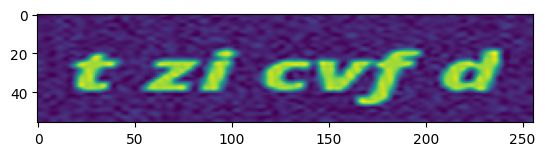

In [11]:
N=15
img, label = next(iter(train_loader))
plt.imshow(img[N])
plt.show()